In [1]:
from process_edus import EDUSample

In [2]:
data = EDUSample()
path = r'../LabeledEDUS.txt'

edus, targets = data.read_labeled(path)


=====> DATA LOADED


In [3]:
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.initializers import Constant
from keras.layers import Input, Dense, Flatten, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D

Using TensorFlow backend.


In [4]:
GLOVE_PATH = r'../../../GloVe/glove.6B.100d.txt'

In [5]:
# tokenize edus
t = Tokenizer()
t.fit_on_texts(edus)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_edus = t.texts_to_sequences(edus)

# pad documents to a max length of 4 words
max_length = 1 << (max(map(lambda x: len(x), encoded_edus)) - 1).bit_length()
padded_edus = pad_sequences(encoded_edus, maxlen=max_length)

split data

In [6]:
X_train, y_train, X_test, y_test = data.split_data(padded_edus, targets)

Preparing embedding matrix

In [7]:
print('Preparing embedding matrix.')
# load the whole embedding into memory
embeddings_index = dict()
f = open(GLOVE_PATH)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.
Loaded 400000 word vectors.


keras model

In [11]:
print('Model Setup') 

inputs = Input(shape=(max_length,), dtype='int32')
embed_sequence = Embedding(vocab_size, 100, 
                           embeddings_initializer=Constant(embedding_matrix), 
                           input_length=max_length,
                           trainable=False)(inputs)

x = Conv1D(128, 5, activation='relu')(embed_sequence)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='softmax')(x)

model = Model(inputs, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print('Fitting model')
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=5)

Model Setup
Fitting model
Train on 1709 samples, validate on 855 samples
Epoch 1/5
1709/1709 [==============================] - 4s 2ms/step - loss: 8.1158 - acc: 0.4909 - val_loss: 8.4280 - val_acc: 0.4713
Epoch 2/5
1709/1709 [==============================] - 2s 1ms/step - loss: 8.1158 - acc: 0.4909 - val_loss: 8.4280 - val_acc: 0.4713
Epoch 3/5
1709/1709 [==============================] - 2s 1ms/step - loss: 8.1158 - acc: 0.4909 - val_loss: 8.4280 - val_acc: 0.4713
Epoch 4/5
1709/1709 [==============================] - 2s 1ms/step - loss: 8.1158 - acc: 0.4909 - val_loss: 8.4280 - val_acc: 0.4713
Epoch 5/5
1709/1709 [==============================] - 2s 1ms/step - loss: 8.1158 - acc: 0.4909 - val_loss: 8.4280 - val_acc: 0.4713


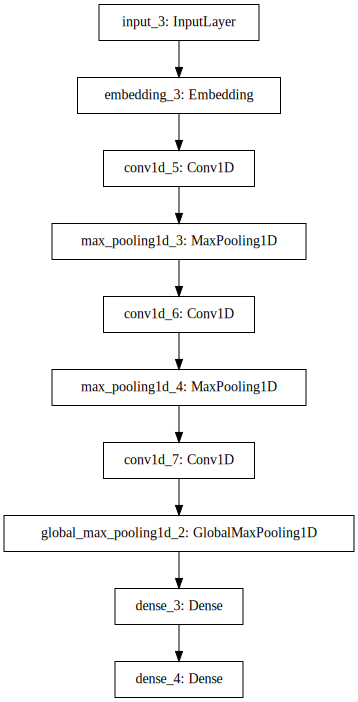

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))